## Simulating evolution with COMETS

`COMETS` is able to perform simulations that include the appearance of mutants containing reaction deletions and additions. In this small example, we will perform a serial transfer experiment starting with a clonal *Escherichia coli* population, and simulate the random appearance of reaction deletion mutants. We will then visualize the dynamics of all genotypes in time.

### Load the model
We start by importing the necessary libraries and loading the *E. coli* model. 

In [2]:
import cometspy as c
import cobra.test
import os
import pandas as pd
import matplotlib.pyplot as plt

# load model 
wt = cobra.test.create_test_model("ecoli")

Using license file /home/djordje/gurobi.lic
Academic license - for non-commercial use only


Remove the bounds for all exchange reactions in the model to allow them to be controlled dynamically by `COMETS` 

In [3]:
# Remove bounds from exchange reactions
for i in wt.reactions:
    if 'EX_' in i.id:
        i.lower_bound =-1000.0

### Set up the layout 
We create a well mixed environment with a glucose minimal media. Here, we use the custom `add_typical_trace_metabolites` method to add trace metabolites (ions, metals etc) in unlimited amounts (`static` flag).

In [4]:
# generate layout
test_tube = c.layout()
test_tube.set_specific_metabolite('glc__D_e', 0.0001)
test_tube.add_typical_trace_metabolites(amount=1000)

# add model
wt = c.model(wt)
wt.initial_pop = [0, 0, 1e-7]
test_tube.add_model(wt)

building empty layout model
models will need to be added with layout.add_model()


### Set up simulation parameters
Create a params object, and modify the needed parameters. The simulation in this example simulation consists of 10 days of experiment, with a 1:2 transfer every 3h. The mutation rate will be $10^{-7}$ deletion events per reaction and generation. The `cellSize` parameter sets the amount of biomass that appears when a mutant occurs (i.e., one mutant cell appears).

In [5]:
# .. load parameters and layout from file
evo_params = c.params()

evo_paramsset_param('timeStep', 0.1)             # hours

evo_paramsset_param('maxCycles', 2400)            # simulate 10 serial transfers of 24h each (timeStep = 0.1)
evo_paramsset_param('batchDilution', True)
evo_paramsset_param('dilFactor', 0.5)            # Dilution to apply
evo_paramsset_param('dilTime', 3)                # hours

evo_paramsset_param('evolution', True)
evo_paramsset_param('mutRate', 1e-8)             # 
evo_paramsset_param('cellSize', 1e-10)           # cellSize should always be larger than maxSpaceBiomass
evo_paramsset_param('minSpaceBiomass', 1e-11)    # make sure it is smaller than cell size!


evo_paramsset_param('BiomassLogRate', 1)

### Run the simulation
We now create the COMETS object using the above layout and parameters, and run the simulation. 

In [7]:
# create comets object from the loaded parameters and layout 
evo_simulation = c.comets(test_tube, evo_params)
evo_simulation.JAVA_CLASSPATH = '/home/djordje/Dropbox/COMETS_RUN/lib/jmatio.jar:/home/djordje/Dropbox/COMETS_RUN/lib/jdistlib-0.4.5-bin.jar:/home/djordje/Dropbox/COMETS_RUN/lib/commons-math3-3.6.1.jar:/home/djordje/Dropbox/COMETS_RUN/lib/commons-lang3-3.9.jar:/home/djordje/Dropbox/COMETS_RUN/lib/colt.jar:/home/djordje/Dropbox/COMETS_RUN/lib/concurrent.jar:/home/djordje/Dropbox/COMETS_RUN/bin/comets_2.9.3.jar:/opt/gurobi901/linux64/lib/gurobi.jar'

# run comets simulation
evo_simulation.run()

These are the expected locations for dependencies:
Dependency 			 expected path
__________ 			 _____________
junit			/home/djordje/Dropbox/COMETS_RUN/lib/junit/junit-4.12.jar
hamcrest			/home/djordje/Dropbox/COMETS_RUN/lib/junit/hamcrest-core-1.3.jar
jogl_all			/home/djordje/Dropbox/COMETS_RUN/lib/jogl/jogamp-all-platforms/jar/jogl-all.jar
gluegen_rt			/home/djordje/Dropbox/COMETS_RUN/lib/jogl/jogamp-all-platforms/jar/gluegen-rt.jar
gluegen			/home/djordje/Dropbox/COMETS_RUN/lib/jogl/jogamp-all-platforms/jar/gluegen.jar
gluegen_rt_natives			/home/djordje/Dropbox/COMETS_RUN/lib/jogl/jogamp-all-platforms/jar/gluegen-rt-natives-linux-amd64.jar
jogl_all_natives			/home/djordje/Dropbox/COMETS_RUN/lib/jogl/jogamp-all-platforms/jar/jogl-all-natives-linux-amd64.jar
jmatio			/home/djordje/Dropbox/COMETS_RUN/lib/JMatIO/lib/jamtio.jar
jmat			/home/djordje/Dropbox/COMETS_RUN/lib/JMatIO/JMatIO-041212/lib/jmatio.jar
concurrent			/home/djordje/Dropbox/COMETS_RUN/lib/colt/lib/concurrent.jar
colt			/ho

### Visualize the results 
We can visualize the population dynamics of all species over time (color coded) using standard Python plotting tools.

Text(0,0.5,'Biomass (gr.)')

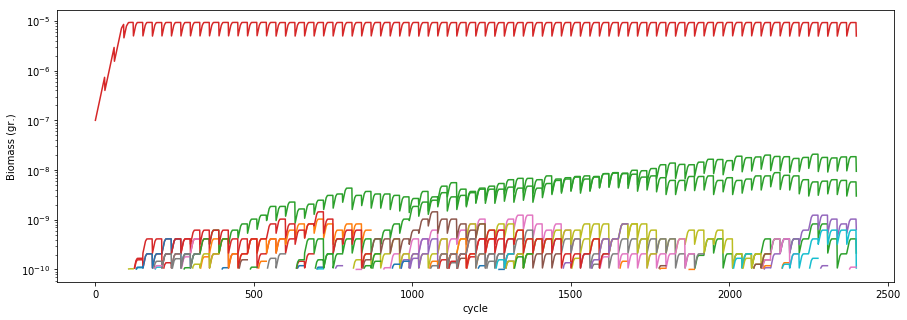

In [8]:
fig, ax = plt.subplots(figsize=(15, 5))

for key, grp in evo_simulation.biomass.groupby(['species']):
    ax = grp.plot(ax=ax, kind='line', x='cycle', y='biomass')
ax.get_legend().remove()
plt.yscale('log')
plt.ylabel("Biomass (gr.)")

In order to analyze the results, it is also helpful to visualize the genotypes data frame, which contains all the mutants that ever appeared during the simulation. The data frame contains three columns: The ancestor, the mutation, and the name of the resulting genotype, which is assigned as a random hash.

In [ ]:
evo_simulation.genotypes